# importing libraries

In [1]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")
import re

# Loading data

In [2]:
cars = pd.read_csv('../../../Data/data_model.csv')

In [3]:
df_cars = cars.copy()  #makinga copy of original data set

print('Original Data Shape:',df_cars.shape)


Original Data Shape: (3813, 41)


Metric	    Target Range

MAE	          2,000–8,000

RMSE	      3,000–12,000

MAPE	      ≤15% (across all prices)

R² Score	  >0.80, ideally >0.85

# Dropping unwanted and unimportant columns

In [4]:
df_cars.columns

Index(['brand', 'model', 'model_year', 'fuel_type', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title', 'price', 'years_used', 'capacity',
       'horsepower', 'cylinder_count', 'mileage_per_year', 'mileage_sqrt',
       'mileage_with_age', 'mileage_per_year_with_age', 'mileage_brand',
       'mileage', 'brand_category', 'log_price', 'power_to_weight_ratio',
       'brand_frequency', 'model_frequency', 'brand_target_enc',
       'model_target_enc', 'mileage_per_year_sqrt', 'mileage_times_age',
       'mileage_sqrt_times_age', 'horsepower_times_cylinder_count',
       'capacity_mileage_interaction', 'age_squared', 'mileage_binned',
       'log_mileage', 'log_capacity', 'capacity_binned', 'horsepower_binned',
       'age_binned', 'trans_num', 'brand_enc'],
      dtype='object')

# Random forest with features

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Function to perform Random Forest Regression
def perform_random_forest_regression(df, target_column, random_state):
    # Splitting the data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Train-test split (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Initialize RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=random_state)

    # Fit the model on the training data
    rf_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Relative Metrics (MAPE and sMAPE)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    smape = np.mean(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100

    # Exponentiate to get the original price scale (since log_price was used)
    y_pred_original = np.exp(y_pred)
    y_test_original = np.exp(y_test)

    # Calculate MAE, MSE, RMSE, and R² for actual prices
    mae_actual = mean_absolute_error(y_test_original, y_pred_original)
    mse_actual = mean_squared_error(y_test_original, y_pred_original)
    rmse_actual = np.sqrt(mse_actual)
    r2_actual = r2_score(y_test_original, y_pred_original)

    # Relative Metrics for actual prices
    mape_actual = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    smape_actual = np.mean(2 * np.abs(y_test_original - y_pred_original) / (np.abs(y_test_original) + np.abs(y_pred_original))) * 100

    # Results
    results = {
        "MAE (Actual Price)": mae_actual,
        "MSE (Actual Price)": mse_actual,
        "RMSE (Actual Price)": rmse_actual,
        "R² Score (Actual Price)": r2_actual,
        "MAPE (mean of absolute percentage error)": mape_actual,
        "sMAPE (same as mape but avoids division by 0)": smape_actual
    }

    return results, y_pred, y_test

# Assuming df is your DataFrame with the target column 'log_price'
col = ['fuel_type', 'transmission', 'capacity', 'mileage_sqrt', 'years_used', 
        'log_price', 'brand', 'horsepower', 'brand_frequency']
col1 =['fuel_type', 'brand','model_frequency','brand_frequency','transmission','years_used', 'capacity_binned','horsepower', 'cylinder_count','log_mileage', 'brand_category', 'log_price']

df_rf = df_cars[col1]

# Apply one-hot encoding for categorical columns (if applicable)
categorical_columns = df_rf.select_dtypes(include=['object', 'category']).columns.to_list()
df_rf = pd.get_dummies(df_rf, columns=categorical_columns, drop_first=True)

# Run Random Forest regression
results_rf, y_pred_rf, y_test_rf = perform_random_forest_regression(df_rf, target_column='log_price',random_state=50)

# Display the results
for metric, value in results_rf.items():
    print(f"{metric}: {value}")


MAE (Actual Price): 8407.762756083466
MSE (Actual Price): 257869306.92851883
RMSE (Actual Price): 16058.309591252711
R² Score (Actual Price): 0.8738044096140574
MAPE (mean of absolute percentage error): 21.56903712353713
sMAPE (same as mape but avoids division by 0): 20.58084812893179


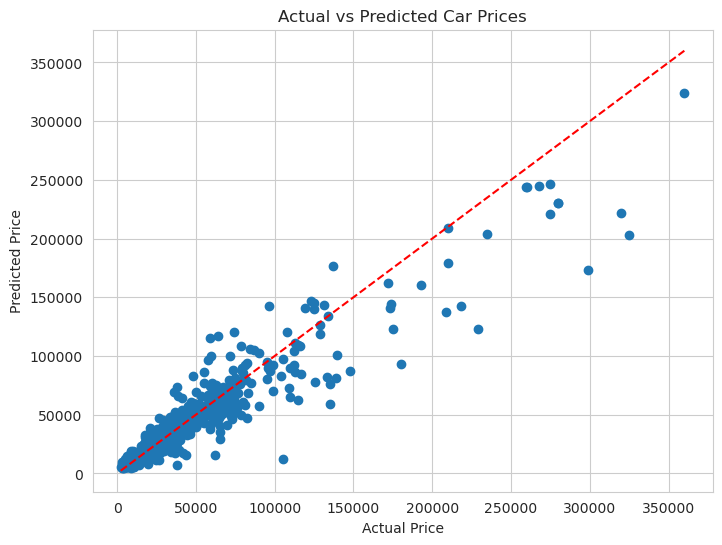

In [6]:
y_pred_original_rf = np.exp(y_pred_rf)
y_test_original_rf = np.exp(y_test_rf)
residuals_rf = y_test_rf - y_pred_rf


plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_rf, y_pred_original_rf)
plt.plot([min(y_test_original_rf), max(y_test_original_rf)], [min(y_test_original_rf), max(y_test_original_rf)], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.savefig('RF_price_comparison.png')
plt.show()

In [7]:
mean_residual_rf = np.mean(residuals_rf)
std_residual_rf = np.std(residuals_rf)
outlier_mask_rf = (residuals_rf > mean_residual_rf + 3 * std_residual_rf) | (residuals_rf < mean_residual_rf - 3 * std_residual_rf)


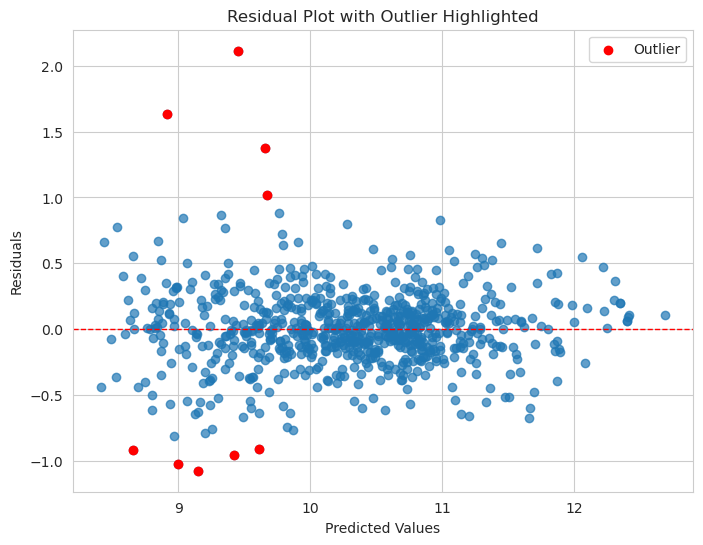

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.7)
plt.scatter(y_pred_rf[outlier_mask_rf], residuals_rf[outlier_mask_rf], color='red', label='Outlier')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.title("Residual Plot with Outlier Highlighted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.savefig('RF_residuals.png')
plt.show()

In [9]:
# Remove the outlier
y_test_filtered_rf = y_test_rf[~outlier_mask_rf]
y_pred_filtered_rf = y_pred_rf[~outlier_mask_rf]


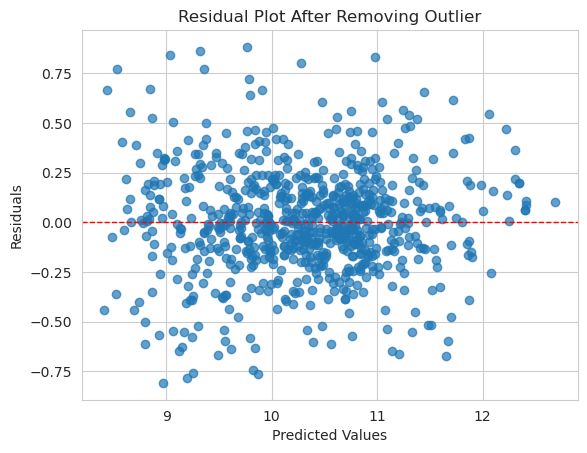

In [10]:
residuals_filtered_rf = y_test_filtered_rf - y_pred_filtered_rf
plt.scatter(y_pred_filtered_rf, residuals_filtered_rf, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Plot After Removing Outlier")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [11]:
outlier_indices_rf = np.where(outlier_mask_rf)[0]
print("Outlier Indices:", outlier_indices_rf)

Outlier Indices: [ 38  75 155 361 510 570 583 707 750]


In [12]:
# Assuming your dataset is in a DataFrame called df
outlier_data_rf = df_rf.iloc[outlier_indices_rf]
print("Outlier Data Points:")
print(outlier_data_rf)

Outlier Data Points:
     model_frequency  brand_frequency  years_used  capacity_binned  \
38                 5              367        10.0              2.0   
75                 1               47         7.0              2.0   
155                1              105        14.0              4.0   
361                2              196         2.0              4.0   
510                4              111        17.0              4.0   
570                6              287         3.0              4.0   
583                3              373         3.0              2.0   
707                3              143         1.0              4.0   
750                1               63        17.0              2.0   

     horsepower  cylinder_count  log_mileage  log_price  fuel_type_Flex Fuel  \
38   240.000000             4.0    11.156265   9.903538                False   
75   340.000000             6.0    10.778977  10.308986                False   
155  275.000000             8.0    10.

In [13]:
from scipy import stats

# Calculate z-scores
z_scores_rf = stats.zscore(residuals_rf)

# Identify points with z-scores greater than 3 (or less than -3, depending on threshold)
outliers_rf = np.where(np.abs(z_scores_rf) > 3)
print("Outlier indices:", outliers_rf)

Outlier indices: (array([ 38,  75, 155, 361, 510, 570, 583, 707, 750]),)


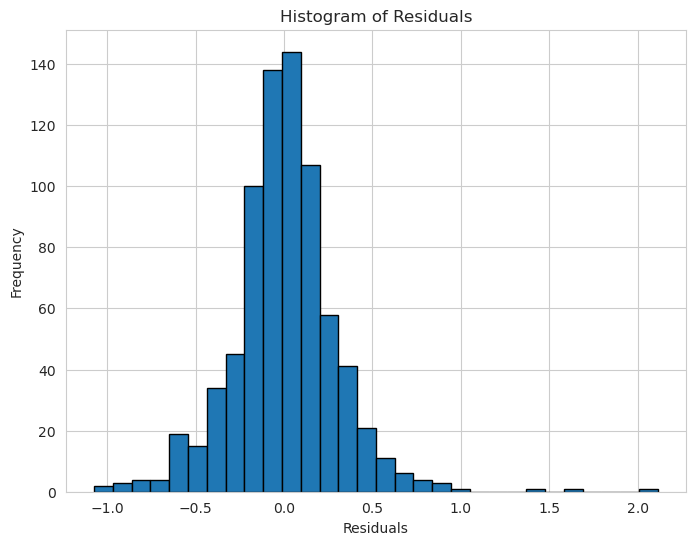

In [14]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals_rf, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.savefig('RF_residual_hist.png')
plt.show()

## hyperparameter tuning

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Function to perform hyperparameter tuning for Random Forest
def tune_random_forest(X, y, random_state):
    # Define the hyperparameters grid
    # param_grid = {
    #     'n_estimators': [50,100,150],  # Number of trees in the forest
    #     'max_depth': [10, 20, None],  # Maximum depth of the trees
    #     'min_samples_split': [2, 10],  # Minimum number of samples to split an internal node
    #     'min_samples_leaf': [1, 5],  # Minimum number of samples at a leaf node
    #     'max_features': ['sqrt', 'log2']  # Number of features to consider
    # }
    param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],  # Limit depth of trees to avoid overfitting and speed up training
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
    }
    # Create a Random Forest Regressor
    rf_model = RandomForestRegressor(random_state=random_state)

    # Set up GridSearchCV with cross-validation
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    # Fit the model
    grid_search.fit(X, y)

    # Print the best hyperparameters and score
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Cross-validation Score:", grid_search.best_score_)

    # Use the best parameters to train the model and evaluate
    best_model = grid_search.best_estimator_
    return best_model

# Assuming df_poly is your preprocessed DataFrame and 'log_price' is the target
col = ['fuel_type', 'transmission', 'capacity_binned', 'mileage_sqrt', 'years_used', 
        'log_price', 'brand', 'horsepower', 'brand_frequency']
col1 =['fuel_type', 'brand','model_frequency','brand_frequency','transmission','years_used', 'capacity_binned','horsepower', 'cylinder_count','log_mileage', 'brand_category', 'log_price']
df=df_cars[col1]

# Apply one-hot encoding for categorical columns (if applicable)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.to_list()
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


X = df.drop('log_price', axis=1)
y = df['log_price']

rndm_state=50

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rndm_state)
# Tune the Random Forest model
best_rf_model = tune_random_forest(X_train, y_train,rndm_state)

# Predict and evaluate using the best model
y_pred = best_rf_model.predict(X_test)

# Exponentiate to get the original price scale (since log_price was used)
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)
# Calculate MAE, MSE, RMSE, and R² for actual prices
mae_actual = mean_absolute_error(y_test_original, y_pred_original)
mse_actual = mean_squared_error(y_test_original, y_pred_original)
rmse_actual = np.sqrt(mse_actual)
r2_actual = r2_score(y_test_original, y_pred_original)
# Relative Metrics for actual prices
mape_actual = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
smape_actual = np.mean(2 * np.abs(y_test_original - y_pred_original) / (np.abs(y_test_original) + np.abs(y_pred_original))) * 100

print(f"MAE (Actual Price): {mae_actual}")
print(f"MSE (Actual Price): {mse_actual}")
print(f"RMSE (Actual Price): {rmse_actual}")
print(f"R² Score (Actual Price): {r2_actual}")
print(f"MAPE (mean of absolute percentage error): {mape_actual:.2f}%")
print(f"sMAPE (same as mape but avoids division by 0): {smape_actual:.2f}%")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_

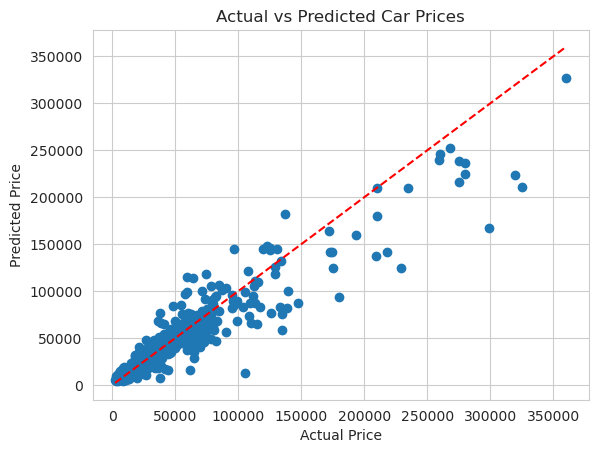

In [16]:

residuals = y_test - y_pred

plt.scatter(y_test_original, y_pred_original)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.show()

In [17]:
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
outlier_mask = (residuals > mean_residual + 3 * std_residual) | (residuals < mean_residual - 3 * std_residual)


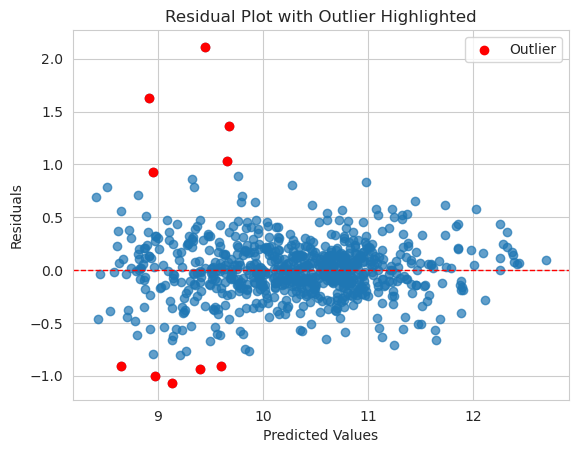

In [18]:
plt.scatter(y_pred, residuals, alpha=0.7)
plt.scatter(y_pred[outlier_mask], residuals[outlier_mask], color='red', label='Outlier')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.title("Residual Plot with Outlier Highlighted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [19]:
# Remove the outlier
y_test_filtered = y_test[~outlier_mask]
y_pred_filtered = y_pred[~outlier_mask]


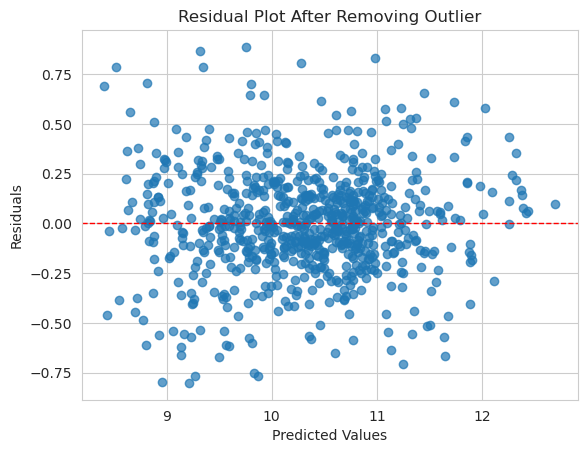

In [20]:
residuals_filtered = y_test_filtered - y_pred_filtered
plt.scatter(y_pred_filtered, residuals_filtered, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Plot After Removing Outlier")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [21]:
outlier_indices = np.where(outlier_mask)[0]
print("Outlier Indices:", outlier_indices)

Outlier Indices: [ 38  75 155 361 401 510 570 583 707 750]


In [22]:
# Assuming your dataset is in a DataFrame called df
outlier_data = df.iloc[outlier_indices]
print("Outlier Data Points:")
print(outlier_data)

Outlier Data Points:
     model_frequency  brand_frequency  years_used  capacity_binned  \
38                 5              367        10.0              2.0   
75                 1               47         7.0              2.0   
155                1              105        14.0              4.0   
361                2              196         2.0              4.0   
401                1              143         2.0              6.0   
510                4              111        17.0              4.0   
570                6              287         3.0              4.0   
583                3              373         3.0              2.0   
707                3              143         1.0              4.0   
750                1               63        17.0              2.0   

     horsepower  cylinder_count  log_mileage  log_price  fuel_type_Flex Fuel  \
38   240.000000        4.000000    11.156265   9.903538                False   
75   340.000000        6.000000    10.778977  10

In [23]:
from scipy import stats

# Calculate z-scores
z_scores = stats.zscore(residuals)

# Identify points with z-scores greater than 3 (or less than -3, depending on threshold)
outliers = np.where(np.abs(z_scores) > 3)
print("Outlier indices:", outliers)

Outlier indices: (array([ 38,  75, 155, 361, 401, 510, 570, 583, 707, 750]),)


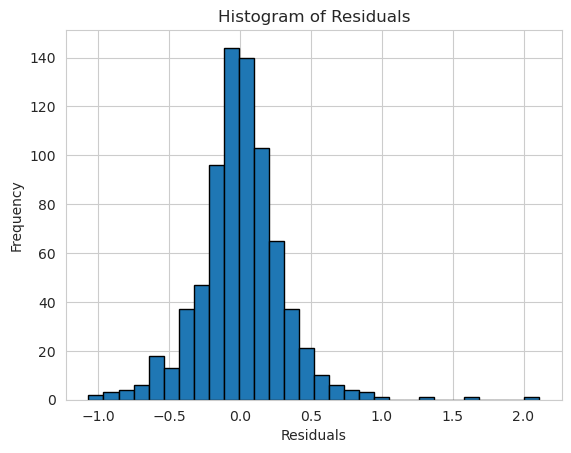

In [24]:
# Histogram of residuals
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()